# Human Detection using HOG Feature and SVM Classifier

In [13]:
from skimage.feature import hog
#from skimage.io import imread
import joblib,glob,os,cv2

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np 
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

from google.colab import files

In [57]:
files.upload()

Saving burmese-moks.jpg to burmese-moks.jpg


{'burmese-moks.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc2\x00\x11\x08\x01\xaa\x02\x80\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x01\x05\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x00\x01\x02\x04\x05\x06\x07\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x01\xf3D\xcf\x1a)4\x81\x8b\t&C\x0c\xb1T\xa1d\x17\x13M!\xb0\xc9\x01:\x93\x8d\x04\xc2\x07 \xca8\x8c\xb0\x13\xc9\xa6\r\x19\x8c\x11 TA\x88\x86\x0b\xb4\xed\x80\xdapL*J\xa6.\xf2\x01\xa9D\x11\xa14\xe7X\x91\x02\xc9\x88\x81\xbc\x1c \xc9\xa9I<A<X\x1c\xc0\xb

In [ ]:
! unzip /content/DATAIMAGE.zip

### HOG Features

In [23]:
def feature_extract(img):
  fd = cv2.resize(img,(64,128))
  fd,hog_image = hog(fd,orientations=9,pixels_per_cell=(8,8),visualize=True,cells_per_block=(3,3))
  return hog_image

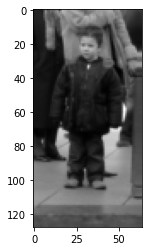

In [24]:
test_image = "/content/DATAIMAGE/positive/crop001001d.png"
img = cv2.imread(test_image,0)
plt.imshow(img,cmap='gray')

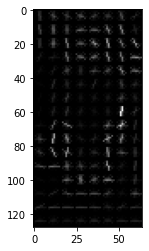

In [25]:
result = feature_extract(img)
plt.imshow(result,cmap='gray')

### Data Preparation

In [1]:
X = []
Y = []

pos_im_path = '/content/DATAIMAGE/positive'
neg_im_path = '/content/DATAIMAGE/negative'

In [3]:
# Load the positive features
for filename in glob.glob(os.path.join(pos_im_path,"*.png")):
    fd = cv2.imread(filename,0)
    fd = cv2.resize(fd,(64,128))
    fd = hog(fd,orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
    X.append(fd)
    Y.append(1)

In [4]:
# Load the negative features
for filename in glob.glob(os.path.join(neg_im_path,"*.jpg")):
    fd = cv2.imread(filename,0)
    fd = cv2.resize(fd,(64,128))
    fd = hog(fd,orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
    X.append(fd)
    Y.append(0)

In [5]:
X = np.float32(X)
Y = np.array(Y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [8]:
print('Train Data:',len(X_train))
print('Train Labels (1,0)',len(y_train))

Train Data: 4520
Train Labels (1,0) 4520


### Model Training

In [9]:
model = LinearSVC()
model.fit(X_train,y_train)

LinearSVC()

In [10]:
# predict
y_pred = model.predict(X_test)

In [11]:
# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report 

print(f"Classification report for classifier {model}:\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

Classification report for classifier LinearSVC():
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       632
           1       0.91      0.93      0.92       498

    accuracy                           0.93      1130
   macro avg       0.93      0.93      0.93      1130
weighted avg       0.93      0.93      0.93      1130




### Demo

In [27]:
joblib.dump(model, 'models.dat')
print('Model saved : {}'.format('models.dat'))

Model saved : models/models.dat


sc:  [0.8613217814068073, 1.1673644398680338, 0.5910647824444075, 0.7975331074023886, 1.9484972011682988, 0.8343136811737255, 0.6814722303700129, 0.8150353319750534, 1.0233563650977098, 0.5781187868621747, 1.1729173687118537, 1.1030581909049608]


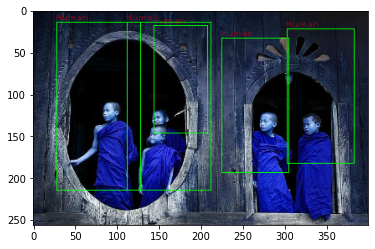

In [66]:
import numpy as np 
import cv2,joblib
from imutils.object_detection import non_max_suppression
import imutils
from skimage.feature import hog
from skimage import color
from skimage.transform import pyramid_gaussian

filename = "/content/burmese-moks.jpg"

image = cv2.imread(filename)
image = cv2.resize(image,(400,256))
size = (64,128)
step_size = (9,9)
downscale = 1.25
#List to store the detections
detections = []
#The current scale of the image 
scale = 0
model = joblib.load('models.dat')

def sliding_window(image, window_size, step_size):
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y: y + window_size[1], x: x + window_size[0]])

for im_scaled in pyramid_gaussian(image, downscale = downscale):
    #The list contains detections at the current scale
    if im_scaled.shape[0] < size[1] or im_scaled.shape[1] < size[0]:
        break
    for (x, y, window) in sliding_window(im_scaled, size, step_size):
        if window.shape[0] != size[1] or window.shape[1] != size[0]:
            continue
        window = color.rgb2gray(window)
            
        fd=hog(window, orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
        fd = fd.reshape(1, -1)
        pred = model.predict(fd)
        if pred == 1:
                
            if model.decision_function(fd) > 0.5:
                detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), model.decision_function(fd), 
                int(size[0] * (downscale**scale)),
                int(size[1] * (downscale**scale))))
 
    scale += 1
clone = image.copy()
rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections])
sc = [score[0] for (x, y, score, w, h) in detections]
print ("sc: ", sc)
sc = np.array(sc)
pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.5)
for(x1, y1, x2, y2) in pick:
    cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 255, 0))
    cv2.putText(clone,'Human',(x1-2,y1-2),1,0.75,(121,12,34),1)

plt.imshow(clone)